In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm, moment
from scipy.optimize import minimize

from cosmoprimo import *
from pycorr import TwoPointCorrelationFunction

from densitysplit import catalog_data, density_split
from densitysplit.split_model import *
from densitysplit.corr_func_utils import *
from densitysplit.utils import *

plt.style.use(os.path.join(os.path.abspath(''), 'densitysplit.mplstyle'))

# To activate logging
setup_logging()

2024-03-18 14:36:37.611681: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:67] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /datablock:/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/conda/lib:/feynman/work/dphp/adematti/cosmo/cosmodesiconda/20230918-1.0.0/common/planck/code/plc_3.0/plc-3.1/lib:/opt/rhel-7.x86_64/gnu/hdf5/1.12.0/lib:/opt/rhel-7.x86_64/gnu4.9/openmpi/1.10.2/lib:/opt/rhel-7.x86_64/gnu/gsl/2.1/lib:/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/aux/lib
2024-03-18 14:36:37.611712: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:264] failed call to cuInit: UNKNOWN ERROR (303)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
plt.rcParams["figure.figsize"] = (5, 4)
plt.rcParams['figure.dpi'] = 100

## Global parameters

In [3]:
# Mock parameters
boxsize = 2000
boxcenter = 0
nmesh = 1024
cosmology = fiducial.AbacusSummitBase()
z = 0.8

# Mocks
nmocks = 10

# Density smoothing parameters
resampler = 'tsc'
cellsize = 10

## Gaussian model

In [10]:
model = SplitCCFModel(redshift=z, cosmology=cosmology, bias=1, nbar=0.003, damping=False, non_linear=True)

/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/code/cosmoprimo/main/lib/python3.10/site-packages/cosmoprimo/interpolator.py:359: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = (np.asarray(xx, dtype=dtype) for xx in (x, y))


## Average density

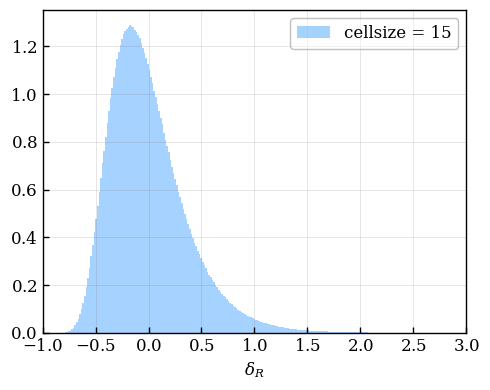

In [4]:
particles_delta_R = np.load('/feynman/work/dphp/mp270220/outputs/density/AbacusSummit_2Gpc_z{:.3f}_downsampled_particles_nbar0.003_cellsize{}_resampler{}_delta_R.npy'.format(z, cellsize, resampler))

plt.hist(particles_delta_R, bins=500, density=True, alpha=0.4, color='C0', label=r'cellsize = 15')
plt.xlabel(r'$\delta_R$')
plt.xlim((-1, 3))
plt.legend()
plt.show()

In [5]:
def compute_delta0_sigma_from_moments(delta_R, m2=None, m3=None):
    if m2 is None:
        m2 = np.mean(delta_R**2) #moment(delta_R, 2)
    if m3 is None:
        m3 = np.mean(delta_R**3) #moment(delta_R, 3)
    def tomin(delta0):
        return (m3 - 3/delta0 * m2**2 - 1/delta0**3 * m2**3)**2
    res = minimize(tomin, x0=1.)
    delta0 = res.x[0]
    sigma = np.sqrt(np.log(1 + m2/res.x[0]**2))
    return delta0, sigma

delta0, sigma = compute_delta0_sigma_from_moments(particles_delta_R)
print(delta0, sigma)

0.9711193674625868 0.3661967062628833


In [7]:
def friedrich_lognormal_model(delta, sigma, delta0):
    pdf_model = np.zeros_like(delta)
    pdf_model[delta > -delta0] = scipy.stats.lognorm.pdf(delta[delta > -delta0], sigma, -delta0, delta0 * np.exp(-sigma**2 / 2))
    return pdf_model

delta = np.linspace(-1, 4, 200)

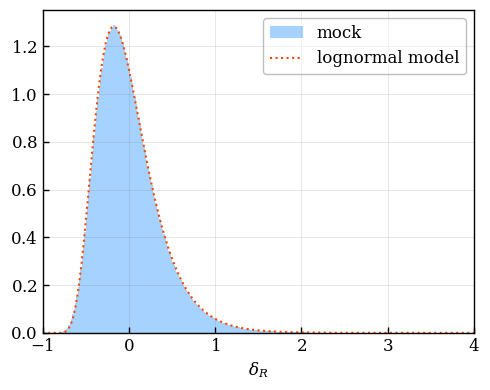

In [9]:
pdf_delta_R = plt.hist(particles_delta_R, bins=500, density=True, alpha=0.4, color='C0', label=r'mock')
plt.plot(delta, friedrich_lognormal_model(delta, sigma, delta0), color='C1', ls=':', label=r'lognormal model')
plt.xlabel(r'$\delta_R$')
plt.xlim((-1, 4))
plt.legend()
plt.show()

In [23]:
output_dir = '/feynman/work/dphp/mp270220/outputs/correlation_functions/'
xiR_abacus_nbar003 = np.load(output_dir+'AbacusSummit_2Gpc_z0.800_downsampled_particles_nbar0.003_cellsize{:d}_resampler{}_xi_R.npy'.format(cellsize, resampler), allow_pickle=True)
sep, xiR_ells_abacus_nbar003 = xiR_abacus_nbar003.item().get_corr(ells=(0), return_sep=True)

## Lognormal model for density splits

In [14]:
nsplits = 5
th_bins = np.array([-1., -0.30384557, -0.14344111, 0.02530601, 0.26483449, np.inf])

In [32]:
def compute_main_term(delta, sigma, delta0=1., delta0_R=1., bias=1., xi_R=None, shotnoise=None):
    if xi_R is None:
        xi_R = model.xi_R * bias**2
        if shotnoise is not None:
            xi_R = (model.xi_R + shotnoise) * bias**2
    if math.isfinite(delta):
        a = scipy.special.erf((np.log(1 + delta/delta0_R) + sigma**2/2. - np.log(1 + xi_R/(delta0*delta0_R))) / (np.sqrt(2) * sigma))
        b = scipy.special.erf((np.log(1 + delta/delta0_R) + sigma**2/2.) / (np.sqrt(2) * sigma))
    else:
        if delta > 0:
            a = np.full_like(xi_R, 1)
            b = np.full_like(xi_R, 1)
        if delta < 0:
            a = np.full_like(xi_R, -1)
            b = np.full_like(xi_R, -1)
    return a, b

def compute_dsplits(sigma, delta0=1., delta0_R=1., th_bins=th_bins, bias=1., xi_R=None, shotnoise=None):
    dsplits = list()

    for i in range(len(th_bins)-1):
        d1 = max(th_bins[i], -delta0_R)
        d2 = th_bins[i+1]
        a1, b1 = compute_main_term(d1, sigma, delta0=delta0, delta0_R=delta0_R, bias=bias, xi_R=xi_R, shotnoise=shotnoise)
        a2, b2 = compute_main_term(d2, sigma, delta0=delta0, delta0_R=delta0_R, bias=bias, xi_R=xi_R, shotnoise=shotnoise)
        main_term = (a2 - a1) / (b2 - b1)
        dsplits.append(delta0*(main_term - 1))

    return dsplits

In [33]:
ells = (0, 2, 4)

/tmp/ipykernel_449012/2605150651.py:7: RuntimeWarning: divide by zero encountered in log
  a = scipy.special.erf((np.log(1 + delta/delta0_R) + sigma**2/2. - np.log(1 + xi_R/(delta0*delta0_R))) / (np.sqrt(2) * sigma))
/tmp/ipykernel_449012/2605150651.py:8: RuntimeWarning: divide by zero encountered in log
  b = scipy.special.erf((np.log(1 + delta/delta0_R) + sigma**2/2.) / (np.sqrt(2) * sigma))


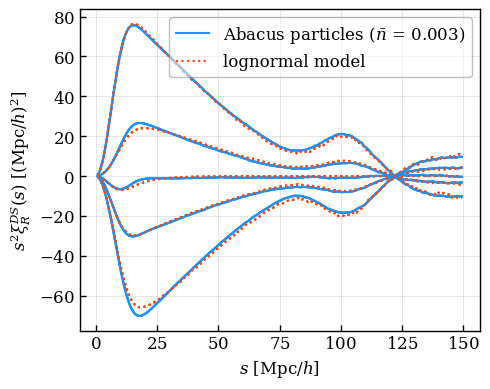

In [34]:
dsplits = compute_dsplits(sigma=sigma, delta0=1., delta0_R=delta0, bias=1., xi_R=xiR_ells_abacus_nbar003)

split_xi_abacus_particles_nbar003 = np.load(output_dir+'AbacusSummit_2Gpc_z0.800_downsampled_particles_nbar0.003_cellsize{:d}_resampler{}_{:d}splits_randoms_size4'.format(cellsize, resampler, nsplits)+'_RH_CCF.npy', allow_pickle=True)
split_xi_abacus_particles_nbar003 = split_xi_abacus_particles_nbar003.item()['rh']
split_xi_ells_abacus_particles_nbar003 = [split_xi_abacus_particles_nbar003[ds].get_corr(ells=ells) for ds in range(nsplits)]
sep, _ = split_xi_abacus_particles_nbar003[0].get_corr(ells=ells, return_sep=True)

for ill, ell in enumerate(ells):
    for ds in range(nsplits):
        plt.plot(sep, sep**2 * split_xi_ells_abacus_particles_nbar003[ds][0], ls='-', color='C0', alpha=1)
        plt.plot(sep, sep**2 * dsplits[ds], ls=':', color='C1')

plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

plt.plot([], [], label=r'Abacus particles ($\bar{n}$ = 0.003)', ls='-', color='C0', alpha=1)
plt.plot([], [], label=r'lognormal model', ls=':', color='C1', alpha=1)

plt.legend()

plt.ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.show()